# Plots for Barcharts

#### Content
* [Coding Productivity Tables](#codeprod)  
* [Performance Plots Algorithms with input matrix](#perf_mat)  
    - [Performance Plots Connected Components](#perf_cc)   
* [Performance Plots Algorithms without input matrix](#perf_nomat)  
    - [Performance Plots Merge Sort](#perf_ms)  
    - [Performance Plots Pi-Approximation](#perf_pi)      
    - [Performance Plots N-Body Simulation](#perf_nbody)   
* [Python 3.14 no GIL tests](#python)  


##### Packages and main formatting parameters

In [1]:
# executed in conda environment 'plotting' ./conda_envs/plotting

# packages and overall options
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.lines as mlines
import glob
import json
import sys
import math

bol_paper = True

if bol_paper:
    sns.set(style='white', font='serif', font_scale=1.5)
    # fontsize for annotation
    font_size = 14
    fig_width = 9
    fig_height = 4
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 4
    plt.rcParams['ytick.major.size'] = 4
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True   
    # out path
    out_folder = ''
    legend_anchor=1.2
else:
    sns.set(style='white', font='sans serif', font_scale=1.3)
    # fontsize for annotation
    font_size = 14
    # figur width and height
    fig_width = 10
    fig_height = 4
    # Set Seaborn style without grid
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    # out path
    out_folder = 'presentations'
    legend_anchor=1.2

# colors
# custom_palette = sns.color_palette('colorblind')
# we use the IBM color design which looks ok for all:https://forum.shotcut.org/t/palette-for-colour-blindness/32219
ibm_colors_hex = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

import matplotlib.colors as mcolors
# Function to lighten colors
def lighten_color(hex_color, factor=0.25):
    """Lightens the given color by blending it with white."""
    rgb = mcolors.hex2color(hex_color)  # Convert to RGB (0-1 range)
    light_rgb = [(1 - factor) * c + factor for c in rgb]  # Blend with white
    return mcolors.to_hex(light_rgb)

# Generate lightened versions of IBM colors
light_ibm_colors_hex = [lighten_color(color, factor=0.25) for color in ibm_colors_hex]

# Add three shades of grey
grey_shades = ['#D3D3D3', '#A9A9A9', '#696969']

# Combine into an extended color palette
extended_colors = ibm_colors_hex + grey_shades + light_ibm_colors_hex

custom_palette = sns.color_palette(extended_colors)

# annotation color on columns
annotate_color='black'


##### Helper functions

In [2]:
def format_with_decimals(value, tick_number):
    return f'{value:.1f}'

def format_thousands_separator(x, digits=0):
    try:
        num = float(x)

        if num.is_integer():
            return '{:,.0f}'.format(num).replace(',', "'")
        else:
            # get the number of decimals, depending on the number of zeros before the comma
            digits = max(0, -int(math.floor(math.log10(abs(num)))))
            return '{:,.{d}f}'.format(num, d=digits).replace(',', "'")
    except (ValueError, TypeError):
        return str(x)

def formatter(ax, rotation=None, axis='y'):
    # Format the y-axis ticks
    if axis == 'y':
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: format_thousands_separator(x, 1)))
    if axis == 'x':
        ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: format_thousands_separator(x, 1)))
    
    ax.tick_params(axis='both', width=0.8)

    if rotation is not None:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right', rotation_mode='anchor')

    # Format legend text (if any)
    if ax.get_legend() is not None:
        for label in ax.get_legend().get_texts():
            label.set_text(format_thousands_separator(label.get_text(), 1))  

def make_grid(ax, plt, ygrid=True, xgrid=False):
    ax.yaxis.grid(ygrid)  # Enable the grid
    ax.xaxis.grid(xgrid)  # Enable the grid
    plt.setp(ax.get_ygridlines(), 'linestyle', '-')  # Set grid line style
    plt.setp(ax.get_ygridlines(), 'linewidth', 0.5)  # Set grid line width
    plt.setp(ax.get_ygridlines(), 'color', 'gray', 'alpha', 0.5)  # Set grid line color
    
    # Enhance grid visibility beneath the bars
    ax.set_axisbelow(True)    
    
    # Customize the box line width
    ax.spines['top'].set_linewidth(0.8)
    ax.spines['right'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['left'].set_linewidth(0.8)

    # Customize tick parameters
    ax.tick_params(axis='both', width=0.5, length=3)

def annotater(ax, plt, annotation_rotated = False, ylim = None):
    
    rot = 90 if annotation_rotated else 0

    # factor for annotated distance
    anotdist = {
        1: 10,
        2: 1,
        3 : 0.1,
    }

    # calculate the division factor for the y-offset
    if ylim is not None:
        # if ylim is given, use it to calculate the division factor
        # division = (ylim[1] - ylim[0]) * anotdist.get(len(str(int(ylim[1]))))
        division = math.log2(ylim[1]) ** 2

    #division = division if annotation_rotated else division  # smaller for better vertical control
    
    # compute max height for relative placement
    max_height = max((p.get_height() for p in ax.patches if p.get_height() > 0), default=1)          

    # automatic selection of number of digits
    if ylim[1] >= 125:
        digits = 0
    else:
        digits = 1
    
    for p in ax.patches:
            height = p.get_height()
            if height > 0:
                # Center horizontally
                x_position = p.get_x() + p.get_width() / 2

                # Slight offset above bar, proportional to height or overall max
                y_offset = max_height / division
                y_position = height + y_offset

                label = format_thousands_separator(height, digits)

                plt.text(
                    x_position,
                    y_position,
                    label,
                    ha='center',
                    va='bottom',
                    rotation=rot,
                    color=annotate_color,
                    fontsize=font_size,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=0.1)
                )
            
def finisher(plot_name, plt):
    # Remove the top and right spines
    #sns.despine(top=True, right=True)   

    # pack everything into the plot size
    plt.tight_layout()

    # Save the plot as SVG
    plt.savefig(os.path.join(path_svg,out_folder,plot_name + '.svg'), format='svg', bbox_inches='tight')
    plt.show()

import matplotlib.lines as lines

## Coding Productivity Tables
<a id='codeprod'></a>

Used to create the plots for the coding productivity metrics:
* Source line of code (SLOC)
* Tokens (TOK)
* Cyclomatic Complexity (CCN)
* Halstead Effort (HAL)

### Read and parse the output for each code produced with *multimetric* tool

In [13]:
# load and read data
path_json = '../coding_productivity/metrics/'

# file name to text mapper
mapper = {
    'cc': 'Connected Components',
    'ms': 'Merge Sort',
    'pi': 'Pi-Approximation',
    'nb': 'N-Body Simulation',    
    'cpp': 'C++\n(cpp)',
    'jl': 'Julia\n(jl)',
    'py': 'Python\n(py)',
    'daph': 'DaphneDSL\n(daph)',
    'seq': 'Seq',
    'par': 'Par',
    'mpi': 'Dist',
}

only_seq = ['Connected Components']

# all JSON files
all_files = glob.glob(os.path.join(path_json,'*.json'))

# read all JSON files and combine them into a single DataFrame
df_list = []
for filepath in all_files:
    
    filename = os.path.basename(filepath)  # Get the filename from the full path

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(filename.split('_')[0], pd.NA)
    lang = mapper.get(filename.split('_')[1], pd.NA)
    typ = mapper.get(filename.split('_')[2].split('.')[0], pd.NA)
    
    # dataframe column names
    col_names=['benchmark',
           'language',
           'type',
           'SLOC',
           'N1',
           'N2',
           'TOC',
           'n1',
           'n2',
           'EFF',
           'CCN']
    
    # load the JSON file
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # find the first (and only) file entry
    file_metrics = next(iter(data['files'].values()))

    # extract your desired metrics
    sloc = file_metrics.get('sloc')
    cyclomatic = file_metrics.get('cyclomatic_complexity')
    halstead_effort = file_metrics.get('halstead_effort')

    n1 = file_metrics.get('operators_uniq')
    n2 = file_metrics.get('operands_uniq')
    N1 = file_metrics.get('operators_sum')
    N2 = file_metrics.get('operands_sum')

    toc = N1 + N2  # total operator and operand occurrences

    # create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=col_names)
    # insert values into the first row (index 0)
    df.loc[0] = [
        algo,        # benchmark
        lang,        # language
        typ,         # type
        int(sloc),   # SLOC
        int(N1),     # N1
        int(N2),     # N2
        int(toc),    # TOC
        int(n1),     # n1
        int(n2),     # n2
        float(halstead_effort),  # EFF
        int(cyclomatic)          # CCN
    ]
        
    df_list.append(df)

    # if the language is DaphneDSL, we add the same values for the 'par' and 'dist' type
    if lang == mapper.get('daph'):
        # create a copy of the DataFrame
        df_dist = df.copy()
        # change the type to 'Dist'
        df_dist['type'] = 'Dist'
        # append the new DataFrame to the list
        df_list.append(df_dist) 
        # create a copy of the DataFrame
        df_par = df.copy()
        # change the type to 'Seq'
        df_par['type'] = 'Par'
        # append the new DataFrame to the list
        df_list.append(df_par)        
    else:     
        # if the algorithms has no sequential implementation, add seq for it
        if algo in only_seq and typ == 'Seq':
            # create a copy of the DataFrame
            df_par = df.copy()
            # change the type to 'Seq'
            df_par['type'] = 'Par'
            # append the new DataFrame to the list
            df_list.append(df_par)
        else:
            continue

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['benchmark', 'language', 'type'],  # keep these as identifiers
    value_vars=['SLOC', 'N1', 'N2', 'TOC', 'n1', 'n2', 'EFF', 'CCN'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(10)


,benchmark,language,type,metric,value
0,Pi-Approximation,Python\n(py),Par,SLOC,35.0
1,N-Body Simulation,C++\n(cpp),Dist,SLOC,142.0
2,N-Body Simulation,Julia\n(jl),Par,SLOC,68.0
3,Connected Components,DaphneDSL\n(daph),Seq,SLOC,12.0
4,Connected Components,DaphneDSL\n(daph),Dist,SLOC,12.0
5,Connected Components,DaphneDSL\n(daph),Par,SLOC,12.0
6,Connected Components,Julia\n(jl),Par,SLOC,67.0
7,Pi-Approximation,Julia\n(jl),Seq,SLOC,25.0
8,Merge Sort,DaphneDSL\n(daph),Seq,SLOC,69.0
9,Merge Sort,DaphneDSL\n(daph),Dist,SLOC,69.0


#### Metric table for LaTeX per benchmark for all metrics 

In [17]:
# create and print the values for the table
# first line all SLOC, TOC, CCN and HAP for the three types for C++, second line Py, third Jl, last DaphneDSL
# elements per line separated with &

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# text_to_add
text_mapper = {
    'cpp' : ['C++', 'cpp', ['Eigen']],
    'py' : ['Python', 'py', ['Numpy, Scipy']],
    'jl' : ['Julia', 'jl', ['MatrixMarket']],
    'daph' : ['DaphneDSL', 'daph', ['$\emptyset$']]
}

# colors for cells
cell_colors = {
    'high': '\\SetCell{bg=myb!20}',
    'less_high': '\\SetCell{bg=myy!20}',
    'medium': '\\SetCell{bg=myo!20}',
    'low': '\\SetCell{bg=myr!20}',
}

color_ranges = {
    'high': (0, 1.5),
    'less_high': (1.5, 2.0),
    'medium': (2.0, 3.0),
    'low': (3.0, float('inf')),
}

# loop over each language to create each row
table_lines = []

for algo in ['Connected Components','Merge Sort','Pi-Approximation', 'N-Body Simulation']:
# for algo in ['Connected Components']:
    df = df_long.copy()
    df = df[df['benchmark'] == algo]
    # title of algorithm row
    title_cells = []
    title_cells.append(f"\\SetCell[c=13]{{halign=l,valign=m}} \\SetCell{{bg=lmyg!20}} \\textbf{{{algo}}} & & & & & & & & & & & &")
    table_lines.append(''.join(title_cells))    

    language_lines = []
    for lang in ['py', 'jl', 'cpp', 'daph']:
        df_lang = df[df['language'] == mapper.get(lang)]
        metric_lines = []  # one line per metric: SLOC, TOC, etc.

        # text columns
        text_cells = []
        # two liner language with abbreviation
        # text_cells.append(f"\\makecell[l]{{{text_mapper.get(lang)[0]} \\\\ \\texttt{{({text_mapper.get(lang)[1]})}}}}")
        # one liner language without abbreviation
        text_cells.append(f"{text_mapper.get(lang)[0]}")
        # # text_cells.append(', '.join(text_mapper.get(lang)[2]))  # dependencies
        # text_cells.append(f"\makecell[c]{{{', '.join(text_mapper.get(lang)[2])}}}")
        metric_lines.append(' & '.join(text_cells))

        for metric in ['SLOC', 'TOC', 'EFF', 'CCN']:
            df_metric = df_lang[df_lang['metric'] == metric]
            seq_base = None
            metric_cells = []  # three per row

            for typ in ['Seq', 'Par', 'Dist']:
                df_typ = df_metric[df_metric['type'] == typ]
                value = df_typ['value'].values[0] if not df_typ.empty else 0
                if typ == 'Seq':
                    seq_base = value if value != 0 else 1
                norm = value / seq_base if seq_base else 0

                norm_rounded = round(norm, 1)
                if color_ranges['high'][0] <= norm_rounded < color_ranges['high'][1] and typ != 'Seq': 
                    cell_color = cell_colors['high']
                elif color_ranges['less_high'][0] <= norm_rounded < color_ranges['less_high'][1] and typ != 'Seq':
                    cell_color = cell_colors['less_high']
                elif color_ranges['medium'][0] <= norm_rounded < color_ranges['medium'][1] and typ != 'Seq':
                    cell_color = cell_colors['medium']
                elif norm_rounded >= color_ranges['low'][0] and typ != 'Seq':
                    cell_color = cell_colors['low']
                else:
                    cell_color = ''
                # two liner cells
                # formatted_value = f"{cell_color} \\makecell[c]{{{norm:.1f} \\\\ \\textit{{{format_thousands_separator(value, 0)}}}}}"
                # onliner cells
                formatted_value = f"{cell_color} {norm:.1f} \\textbar\\ \\textit{{{format_thousands_separator(value, 0)}}}"
                metric_cells.append(formatted_value)

            # join the three cells for one metric
            metric_lines.append(' & '.join(metric_cells))

        # combine all metrics for this language
        language_lines.append(' & \n'.join(metric_lines))

    table_lines.append('\n \\\\ \\hline[dashed]\n'.join(language_lines))

# print the full LaTeX block
print('\n \\\\ \\hline\n'.join(table_lines))


        

\SetCell[c=13]{halign=l,valign=m} \SetCell{bg=lmyg!20} \textbf{Connected Components} & & & & & & & & & & & &
 \\ \hline
Python & 
 1.0 \textbar\ \textit{23} & \SetCell{bg=myb!20} 1.0 \textbar\ \textit{23} & \SetCell{bg=myr!20} 4.6 \textbar\ \textit{105} & 
 1.0 \textbar\ \textit{178} & \SetCell{bg=myb!20} 1.0 \textbar\ \textit{178} & \SetCell{bg=myr!20} 5.8 \textbar\ \textit{1'025} & 
 1.0 \textbar\ \textit{12'884} & \SetCell{bg=myb!20} 1.0 \textbar\ \textit{12'884} & \SetCell{bg=myr!20} 23.9 \textbar\ \textit{307'769} & 
 1.0 \textbar\ \textit{3} & \SetCell{bg=myb!20} 1.0 \textbar\ \textit{3} & \SetCell{bg=myr!20} 4.7 \textbar\ \textit{14}
 \\ \hline[dashed]
Julia & 
 1.0 \textbar\ \textit{67} & \SetCell{bg=myb!20} 1.0 \textbar\ \textit{67} & \SetCell{bg=myy!20} 1.7 \textbar\ \textit{113} & 
 1.0 \textbar\ \textit{358} & \SetCell{bg=myb!20} 1.0 \textbar\ \textit{358} & \SetCell{bg=myo!20} 2.2 \textbar\ \textit{786} & 
 1.0 \textbar\ \textit{55'852} & \SetCell{bg=myb!20} 1.0 \textbar\ 

## Performance Plots for Algorithms with input data
<a id='perf_mat'></a>

Connected Components

Used to create the plots of performance experiments:
* Sequential (Seq)
* Local parallel with threads (A)
* Local parallel with MPI processes (B)
* Distributed bt scaling nodes (C)

### Load results and check for completeness

In [3]:
# Create sets of all experiments configurations --> to verify if all experiments were run
import itertools

typ = ['Seq']
benchmarks = ['cc']
matrices = ['ljournal-2008']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1]
threads = [1]
rep = ['1', '2', '3', '4', '5']  # 5 repetitions]
expected_res = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
print(f"Expected seq experiments: {len(expected_res)}")

# par
typ = ['(A)']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1]
threads = [2,4,8,16,32]
expected_seq_local = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
print(f"Expected par (A) experiments: {len(expected_seq_local)}")
expected_res = expected_res | expected_seq_local

# mpi-local
typ = ['(B)']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1,2,4,8,16,32]
threads = [1]
expected_mpi_local = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
print(f"Expected mpi-local (B) experiments: {len(expected_mpi_local)}")
expected_res = expected_res | expected_mpi_local

# mpi-scale-nodes
# c++, py and jl
typ = ['(C)']
lang = ['cpp', 'py', 'jl']
nodes = [1,2,4,8]
processes = [16]
threads = [1]
expected_mpi_scale = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
# daphne
lang = ['daph']
processes = [1]
threads = [16]
expected_mpi_scale_daph = set(itertools.product(typ, benchmarks, matrices, lang, nodes, processes, threads, rep))
expected_mpi_scale = expected_mpi_scale | expected_mpi_scale_daph
print(f"Expected mpi-scale (C) experiments: {len(expected_mpi_scale)}")

expected_res = expected_res | expected_mpi_scale
print(f"Total expected experiments: {len(expected_res)}")

Expected seq experiments: 20
Expected par (A) experiments: 100
Expected mpi-local (B) experiments: 120
Expected mpi-scale (C) experiments: 80
Total expected experiments: 320


In [5]:
algos='connected_components'
matrixs='ljournal-2008'

# load and read data
paths_results = [
    f'../results/{algos}/{matrixs}/seq/', 
    f'../results/{algos}/{matrixs}/par/', 
    f'../results/{algos}/{matrixs}/mpi_local/', 
    f'../results/{algos}/{matrixs}/mpi_scale_nodes/',                    
]

# set to keep track of results
is_res = set()

# file name to text mapper
mapper = {
    'connected_components': 'Connected Components',
    'Connected Components': 'cc',
    'cpp': 'C++',
    'jl': 'Julia',
    'py': 'Python',
    'daph': 'DAPHNE',
    'seq': 'Seq',
    'mpi_local': '(B)',
    'par': '(A)',
    'mpi_scale_nodes': '(C)',
    'amazon0601': 'amazon0601',
    'wikipedia-20070206': 'wikipedia-20070206',
    'ljournal-2008': 'ljournal-2008',
}

# all DAT files
all_files = []
for path in paths_results:
    all_files.extend(glob.glob(os.path.join(path, '**', '*.dat'), recursive=True))

# read all DAT files and combine them into a single DataFrame
df_list = []

for filepath in all_files:
    
    parts = filepath.split(os.sep)

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(parts[2], pd.NA)
    matrix = mapper.get(parts[3], pd.NA)
    typ = mapper.get(parts[4], pd.NA)
    algo_short = mapper.get(algo, pd.NA)
    lang = mapper.get(parts[5], pd.NA)
    lang_short = parts[5]

    # if some scheduling options used (DAPHNE)
    if len(parts) > 8:
        scheme = parts[6].split('-')[0].upper()
        layout = parts[6].split('-')[1].upper()
        victim = parts[6].split('-')[2].upper()
        parallelism = int(parts[7])
        rep = parts[8].split('.')[0]  # remove the .dat extension
    else:
        scheme = pd.NA
        layout = pd.NA
        victim = pd.NA
        parallelism = int(parts[6])
        rep = parts[7].split('.')[0]  # remove the .dat extension

    # set #nodes, #processes, #threads
    if typ == '(C)':
        nodes = int(parallelism)
        if lang_short == 'daph':
            processes = 1
            threads = 16
        else:
            processes = 16
            threads = 1
    elif typ == '(A)':
        nodes = 1
        processes = 1
        threads = int(parallelism)
    else:
        nodes = 1
        processes = int(parallelism)
        threads = 1

    # dataframe column names
    col_names=['benchmark',
            'language',
            'type',
            'matrix',
            'scheme',
            'layout',
            'victim',
            'nodes',
            'processes-per-node',
            'threads-per-process',
            'rep',
            't-reading',
            't-computation',
            't-end-to-end',
            'result'
           ]
    
    try:
        with open(filepath, 'r') as f:
            line = f.readline()
            values = line.strip().split(",")
            t_ete = float(values[0])
            t_computation = float(values[1])
            result = float(values[2].strip())
    except Exception as e:
        # print(f"Error reading file {filepath}: {e}")
        os.remove(filepath)
        continue

    # if the experiment did not finish properly, the files is still there but empty. delete them for Snakemake to rerun
    if line.strip() == '':
        # print(f"File {filepath}: empty line")
        os.remove(filepath)
        continue

    # total time
    t_read = t_ete - t_computation

    # determine the type of the experiment and add it to the check set if desired and add it to df
    yes=False
    if matrix in [matrixs]:
        if algo_short == mapper.get(mapper.get(algos)):
            if processes <= 32:
                if nodes <= 8:
                    yes = True

    if yes:
        is_res.add((typ, algo_short, matrix, lang_short, nodes, processes, threads, rep))

        # create an empty DataFrame with the specified columns
        df = pd.DataFrame(columns=col_names)
        # insert values into the first row (index 0)
        df.loc[0] = [
            algo,        # benchmark
            lang,        # language
            typ,         # type
            matrix,      # data matrix
            scheme,     
            layout,     
            victim,    
            int(nodes),     
            int(processes),     
            int(threads),
            int(rep),
            float(t_read),
            float(t_computation),  
            float(t_ete), 
            float(result)    
        ]
        
        df_list.append(df)                    

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['benchmark', 'language', 'type', 'matrix', 'scheme', 'layout', 'victim', 'nodes', 'processes-per-node', 'threads-per-process','rep'],  # keep these as identifiers
    value_vars=['t-reading','t-computation','t-end-to-end','result'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(10)
df_long[(df_long['type'] == '(A)') 
        & (df_long['matrix'] == 'ljournal-2008')
        & (df_long['language'] == 'Python') 
        & (df_long['nodes'] == 1)
        & (df_long['processes-per-node'] == 1)
        & (df_long['threads-per-process'] == 2)        
].head(20)
    

,benchmark,language,type,matrix,scheme,layout,victim,nodes,processes-per-node,threads-per-process,rep,metric,value
50,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,2,t-reading,6.497166e+00
51,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,5,t-reading,5.138943e+00
52,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,1,t-reading,1.227693e+01
53,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,4,t-reading,8.132480e+00
54,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,3,t-reading,5.618015e+00
370,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,2,t-computation,3.700763e+02
371,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,5,t-computation,2.230724e+02
372,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,1,t-computation,2.390866e+02
373,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,4,t-computation,2.968695e+02
374,Connected Components,Python,(A),ljournal-2008,NaN,NaN,NaN,1,1,2,3,t-computation,2.319102e+02


In [7]:
# check for missing
print(f"Expected experiments: {len(expected_res)}")
print(f"Found experiments: {len(is_res)}")
print(f"Missing experiments: {len(expected_res - is_res)}")
# print missing experiments
missing_experiments = expected_res - is_res
for exp in missing_experiments:
    print(exp)
print(f"Excess experiments: {len(is_res - expected_res)}")
# print found experiments
excess_experiments = is_res - expected_res
for exp in excess_experiments:
    print(exp)  

Expected experiments: 320
Found experiments: 320
Missing experiments: 0
Excess experiments: 0


### Performance Plots Connected Components
<a id='perf_cc'></a>

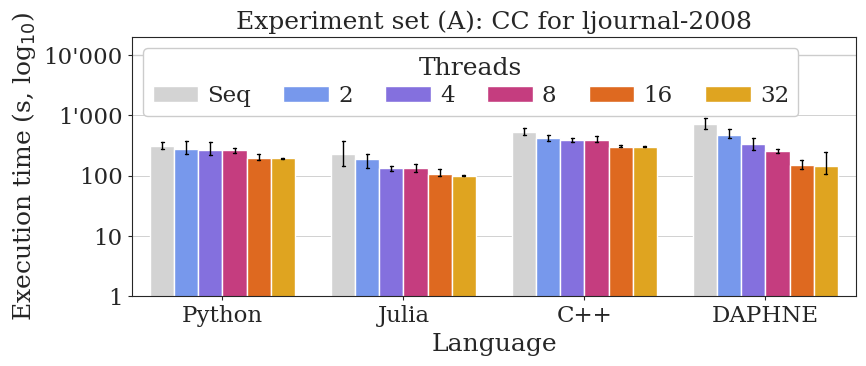

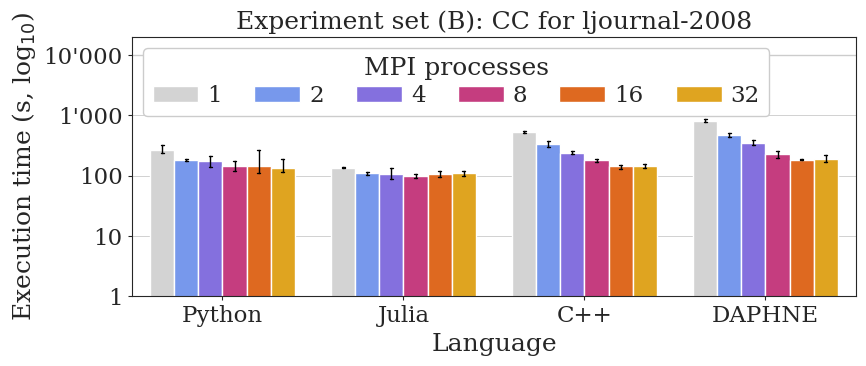

/tmp/ipykernel_1702657/1125636894.py:158: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(


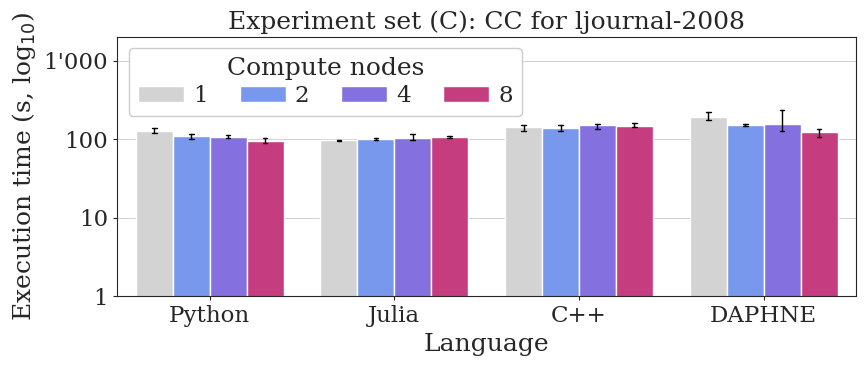

In [6]:
# output path for svg plots
path_svg = './performance/'
algo = 'Connected Components'
log_base = 10

# plots are produced in loops

plot_loop = {
    'A_cc' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'threads-per-process',
        'on_hue_label' : 'Threads',        
        'columns' : ['value', 'language', 'threads-per-process'],
        'filter_cols' : [
            ('threads-per-process', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['Seq', '(A)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (A): CC for ljournal-2008',
        'loc' : 'upper left',   
        'ncol' : 6,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1, 2e4]
    },   
    'B_cc' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'processes-per-node',
        'on_hue_label' : 'MPI processes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('processes-per-node', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['(B)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (B): CC for ljournal-2008',
        'loc' : 'upper left',   
        'ncol' : 6,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1, 2e4]  
    },       
    'C_cc' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'nodes',
        'on_hue_label' : 'Compute nodes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('nodes', [1,2,4,8]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # needed for ordering 
            ('type', ['(C)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (C): CC for ljournal-2008',
        'loc' : 'upper left',   
        'ncol' : 4,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1, 2e3]   
    }, 
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = [t[1] for t in v.get('filter_cols') if t[0] == on_x][0]  # x order from filter_cols
    hue_order = [t[1] for t in v.get('filter_cols') if t[0] == on_hue][0] if on_hue is not None else None  # hue order from filter_cols

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # as Seq and (A) have a 1 thread experiments, remove (A) with 1 thread from df
    df = df[~((df['type'] == '(A)') & (df['threads-per-process'] == 1))]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # # search order as defined in plot loop
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    # x_order = tuple_[1]
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    # hue_order = tuple_[1]

    # print(df)
    # print(data)
    # sys.exit(0)

    # if data[on_hue].nunique() <= 5:
    #     palette_ = custom_palette[:data[on_hue].nunique()]
    # else:
    palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    ax.set_yscale('log', base=log_base)
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.get_major_locator().set_params(numticks=10)

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    leg = plt.legend(title=on_hue_label, 
                     loc=v.get('loc'), 
                     ncol=ncol, 
                     labelspacing=0.2,
                     columnspacing=1.4,
                     handletextpad=0.4
                     )

    # check if list filter_cols contains type and if type contains (A)
    if any(t[0] == 'type' and '(A)' in t[1] for t in v.get('filter_cols')):
        for text in leg.get_texts():
            if text.get_text() in ("1", "1.0"):
                text.set_text("Seq")

    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)

## Performance Plots for non matrix input algorithms
<a id='perf_nomat'></a>

Includes Merge Sort, Pi-Approximation, and N-Body

Used to create the plots of performance experiments:
* Sequential (Seq)
* Local parallel with threads (A)
* Local parallel with MPI processes (B)
* Distributed bt scaling nodes (C)

### Load results and check for completeness

In [8]:
# Create sets of all experiments configurations --> to verify if all experiments were run
import itertools

typ = ['Seq']
benchmarks = ['pi','ms','nbody']
# benchmarks = ['pi']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1]
threads = [1]
rep = ['1', '2', '3', '4', '5']  # 5 repetitions]
expected_res = set(itertools.product(typ, benchmarks, lang, nodes, processes, threads, rep))
print(f"Expected seq experiments: {len(expected_res)}")

# par
typ = ['(A)']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1]
threads = [2,4,8,16,32]
expected_seq_local = set(itertools.product(typ, benchmarks, lang, nodes, processes, threads, rep))
print(f"Expected par (A) experiments: {len(expected_seq_local)}")
expected_res = expected_res | expected_seq_local

# mpi-local
typ = ['(B)']
lang = ['cpp', 'py', 'jl', 'daph']
nodes = [1]
processes = [1,2,4,8,16,32]
threads = [1]
expected_mpi_local = set(itertools.product(typ, benchmarks, lang, nodes, processes, threads, rep))
print(f"Expected mpi-local (B) experiments: {len(expected_mpi_local)}")
expected_res = expected_res | expected_mpi_local

# mpi-scale-nodes
# c++, py and jl
typ = ['(C)']
lang = ['cpp', 'py', 'jl']
nodes = [1,2,4,8]
processes = [16]
threads = [1]
expected_mpi_scale = set(itertools.product(typ, benchmarks, lang, nodes, processes, threads, rep))
# daphne
lang = ['daph']
processes = [1]
threads = [16]
expected_mpi_scale_daph = set(itertools.product(typ, benchmarks, lang, nodes, processes, threads, rep))
expected_mpi_scale = expected_mpi_scale | expected_mpi_scale_daph
print(f"Expected mpi-scale (C) experiments: {len(expected_mpi_scale)}")

expected_res = expected_res | expected_mpi_scale
print(f"Total expected experiments: {len(expected_res)}")

Expected seq experiments: 60
Expected par (A) experiments: 300
Expected mpi-local (B) experiments: 360
Expected mpi-scale (C) experiments: 240
Total expected experiments: 960


In [9]:
algos=['pi_approx', 'mergesort', 'nbody']
# algos=['pi_approx']

# load and read data
paths_results = []
for algo in algos:
    paths_results.append(f'../results/{algo}/seq/')
    paths_results.append(f'../results/{algo}/par/') 
    paths_results.append(f'../results/{algo}/mpi_local/')
    paths_results.append(f'../results/{algo}/mpi_scale_nodes/')                  

# set to keep track of results
is_res = set()

# file name to text mapper
mapper = {
    'pi_approx': 'Pi-Approximation',
    'Pi-Approximation': 'pi',
    'mergesort': 'Merge Sort',
    'Merge Sort': 'ms',
    'nbody': 'N-Body Simulation',
    'N-Body Simulation': 'nbody',
    'cpp': 'C++',
    'jl': 'Julia',
    'py': 'Python',
    'daph': 'DAPHNE',
    'seq': 'Seq',
    'par': '(A)',    
    'mpi_local': '(B)',
    'mpi_scale_nodes': '(C)',
}

# all DAT files
all_files = []
for path in paths_results:
    all_files.extend(glob.glob(os.path.join(path, '**', '*.dat'), recursive=True))

# read all DAT files and combine them into a single DataFrame
df_list = []

for filepath in all_files:
    
    parts = filepath.split(os.sep)

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(parts[2], pd.NA)
    typ = mapper.get(parts[3], pd.NA)
    algo_short = mapper.get(algo, pd.NA)
    lang = mapper.get(parts[4], pd.NA)
    lang_short = parts[4]

    # if some scheduling options used (DAPHNE)
    if len(parts) > 7:
        scheme = parts[5].split('-')[0].upper()
        layout = parts[5].split('-')[1].upper()
        victim = parts[5].split('-')[2].upper()
        parallelism = int(parts[6])
        rep = parts[7].split('.')[0]  # remove the .dat extension
    else:
        scheme = pd.NA
        layout = pd.NA
        victim = pd.NA
        parallelism = int(parts[5])
        rep = parts[6].split('.')[0]  # remove the .dat extension

    # set #nodes, #processes, #threads
    if typ == '(C)':
        nodes = int(parallelism)
        if lang_short == 'daph':
            processes = 1
            threads = 16
        else:
            processes = 16
            threads = 1
    elif typ == '(A)':
        nodes = 1
        processes = 1
        threads = int(parallelism)
    else:
        nodes = 1
        processes = int(parallelism)
        threads = 1

    # dataframe column names
    col_names=['benchmark',
            'language',
            'type',
            'scheme',
            'layout',
            'victim',
            'nodes',
            'processes-per-node',
            'threads-per-process',
            'rep',
            't-reading',
            't-computation',
            't-end-to-end',
            'result'
           ]
    
    try:
        with open(filepath, 'r') as f:
            line = f.readline()
            values = line.strip().split(",")
            t_ete = float(values[0])
            t_computation = float(values[1])
            result = float(values[2].strip())
    except Exception as e:
        # print(f"Error reading file {filepath}: {e}")
        os.remove(filepath)
        continue

    # if the experiment did not finish properly, the files is still there but empty. delete them for Snakemake to rerun
    if line.strip() == '':
        # print(f"File {filepath}: empty line")
        os.remove(filepath)
        continue

    # total time
    t_read = t_ete - t_computation

    # determine the type of the experiment and add it to the check set if desired and add it to df
    yes=False
    if algo_short == mapper.get(algo):
        if processes <= 32:
            if nodes <= 8:
                yes = True
    if typ == '(A)' and threads == 1:
        yes = False
 

    if yes:
        is_res.add((typ, algo_short, lang_short, nodes, processes, threads, rep))

        # create an empty DataFrame with the specified columns
        df = pd.DataFrame(columns=col_names)
        # insert values into the first row (index 0)
        df.loc[0] = [
            algo,        # benchmark
            lang,        # language
            typ,         # type
            scheme,     
            layout,     
            victim,    
            int(nodes),     
            int(processes),     
            int(threads),
            int(rep),
            float(t_read),
            float(t_computation),  
            float(t_ete), 
            float(result)    
        ]
        
        df_list.append(df)             

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['benchmark', 'language', 'type', 'scheme', 'layout', 'victim', 'nodes', 'processes-per-node', 'threads-per-process','rep'],  # keep these as identifiers
    value_vars=['t-reading','t-computation','t-end-to-end','result'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long[(df_long['type'] == '(B)') 
        & df_long['benchmark'].isin(['N-Body Simulation'])
        & (df_long['nodes'] == 1)
        & (df_long['processes-per-node'] == 16)
        & (df_long['threads-per-process'] == 1)  
        & (df_long['metric'] == 't-end-to-end')     
].head(10)

,benchmark,language,type,scheme,layout,victim,nodes,processes-per-node,threads-per-process,rep,metric,value
2700,N-Body Simulation,Julia,(B),NaN,NaN,NaN,1,16,1,2,t-end-to-end,74.206803
2701,N-Body Simulation,Julia,(B),NaN,NaN,NaN,1,16,1,5,t-end-to-end,70.638724
2702,N-Body Simulation,Julia,(B),NaN,NaN,NaN,1,16,1,1,t-end-to-end,73.214862
2703,N-Body Simulation,Julia,(B),NaN,NaN,NaN,1,16,1,4,t-end-to-end,78.345946
2704,N-Body Simulation,Julia,(B),NaN,NaN,NaN,1,16,1,3,t-end-to-end,73.489147
2730,N-Body Simulation,Python,(B),NaN,NaN,NaN,1,16,1,2,t-end-to-end,203.860817
2731,N-Body Simulation,Python,(B),NaN,NaN,NaN,1,16,1,5,t-end-to-end,201.582869
2732,N-Body Simulation,Python,(B),NaN,NaN,NaN,1,16,1,1,t-end-to-end,178.849873
2733,N-Body Simulation,Python,(B),NaN,NaN,NaN,1,16,1,4,t-end-to-end,176.494989
2734,N-Body Simulation,Python,(B),NaN,NaN,NaN,1,16,1,3,t-end-to-end,203.041597


In [10]:
print(f"Expected experiments: {len(expected_res)}")
print(f"Found experiments: {len(is_res)}")
print(f"Missing experiments: {len(expected_res - is_res)}")
# print missing experiments
missing_experiments = expected_res - is_res
missing_experiments = sorted(missing_experiments, key=lambda x: (x[1], x[0], x[3], x[4], x[5], x[6], x[2]))  # sort by algo, type, lang, nodes, processes, threads, rep
for exp in missing_experiments:
    # if exp[0] == '(A)':
    #     print(exp)
    print(exp)

print(f"Excess experiments: {len(is_res - expected_res)}")
# print found experiments
excess_experiments = is_res - expected_res
for exp in excess_experiments:
    print(exp) 

Expected experiments: 960
Found experiments: 960
Missing experiments: 0
Excess experiments: 0


In [11]:
df = df_long.copy()
df = df[(df['benchmark'] == 'N-Body Simulation') 
        & (df['type'] == '(B)') 
        & (df['nodes'] == 1)
        & (df['processes-per-node'] == 16)
        & (df['threads-per-process'] == 1)  
        & (df['metric'] == 't-end-to-end')     
]

# Compute the average over repetitions
df_avg = df.groupby(['benchmark', 'language', 'type', 'nodes', 'processes-per-node', 'threads-per-process', 'metric']).agg({'value': 'mean'}).reset_index()
df_avg.head(10)

# get the C++ value
cpp_value = df_avg[df_avg['language'] == 'C++']['value'].values[0]
df_avg['normalized_value'] = df_avg['value'] / cpp_value
df_avg.head(10)

,benchmark,language,type,nodes,processes-per-node,threads-per-process,metric,value,normalized_value
0,N-Body Simulation,C++,(B),1,16,1,t-end-to-end,1.102848,1.000000
1,N-Body Simulation,DAPHNE,(B),1,16,1,t-end-to-end,35.121360,31.846057
2,N-Body Simulation,Julia,(B),1,16,1,t-end-to-end,73.979096,67.080048
3,N-Body Simulation,Python,(B),1,16,1,t-end-to-end,192.766029,174.789299


### Performance Plots Merge Sort
<a id='perf_ms'></a>


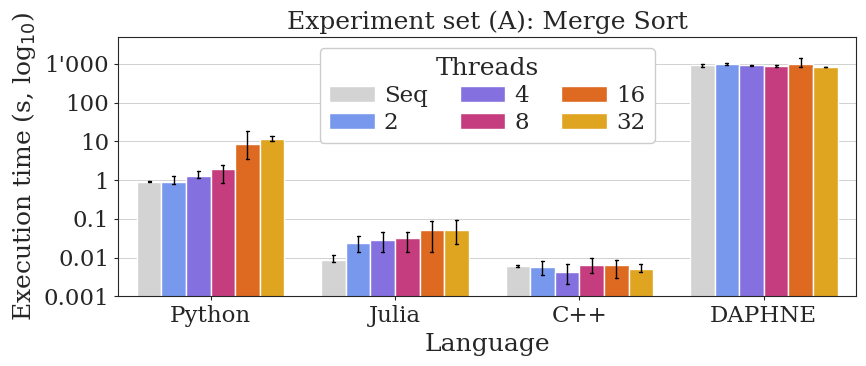

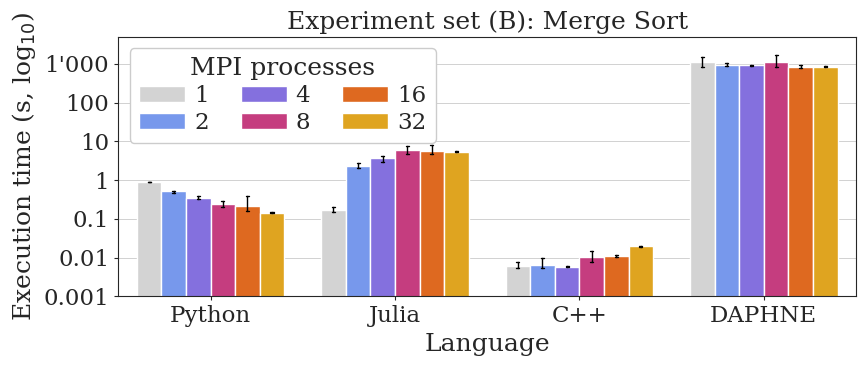

/tmp/ipykernel_1702657/3919933740.py:160: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(


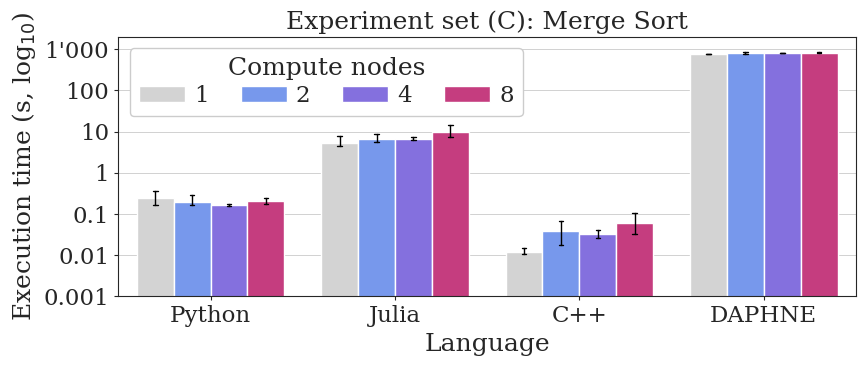

In [12]:
# output path for svg plots
path_svg = './performance/'
algo = 'Merge Sort'
log_base = 10

import matplotlib.ticker as ticker

# plots are produced in loops

plot_loop = {
    'A_ms' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'threads-per-process',
        'on_hue_label' : 'Threads',        
        'columns' : ['value', 'language', 'threads-per-process'],
        'filter_cols' : [
            ('threads-per-process', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['Seq', '(A)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (A): {algo}',
        'loc' : 'upper center',   
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-3, 5e3]
    },   
    'B_ms' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'processes-per-node',
        'on_hue_label' : 'MPI processes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('processes-per-node', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['(B)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (B): {algo}',
        'loc' : 'upper left',   
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-3, 5e3]  
    },       
    'C_ms' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'nodes',
        'on_hue_label' : 'Compute nodes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('nodes', [1,2,4,8]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # needed for ordering 
            ('type', ['(C)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (C): {algo}',
        'loc' : 'upper left',   
        'ncol' : 4,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-3, 2e3]   
    }, 
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = [t[1] for t in v.get('filter_cols') if t[0] == on_x][0]  # x order from filter_cols
    hue_order = [t[1] for t in v.get('filter_cols') if t[0] == on_hue][0] if on_hue is not None else None  # hue order from filter_cols

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # as Seq and (A) have a 1 thread experiments, remove (A) with 1 thread from df
    df = df[~((df['type'] == '(A)') & (df['threads-per-process'] == 1))]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # # search order as defined in plot loop
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    # x_order = tuple_[1]
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    # hue_order = tuple_[1]

    # print(df)
    # print(data)
    # sys.exit(0)

    # if data[on_hue].nunique() <= 5:
    #     palette_ = custom_palette[:data[on_hue].nunique()]
    # else:
    palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    ax.set_yscale('log', base=log_base)
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.get_major_locator().set_params(numticks=10)
    
    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    leg = plt.legend(title=on_hue_label, 
                     loc=v.get('loc'), 
                     ncol=ncol, 
                     labelspacing=0.2,
                     columnspacing=1.4,
                     handletextpad=0.4
                     )

    # check if list filter_cols contains type and if type contains (A)
    if any(t[0] == 'type' and '(A)' in t[1] for t in v.get('filter_cols')):
        for text in leg.get_texts():
            if text.get_text() in ("1", "1.0"):
                text.set_text("Seq")
                
    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)

### Performance Plots Pi-Approximation
<a id='perf_pi'></a>

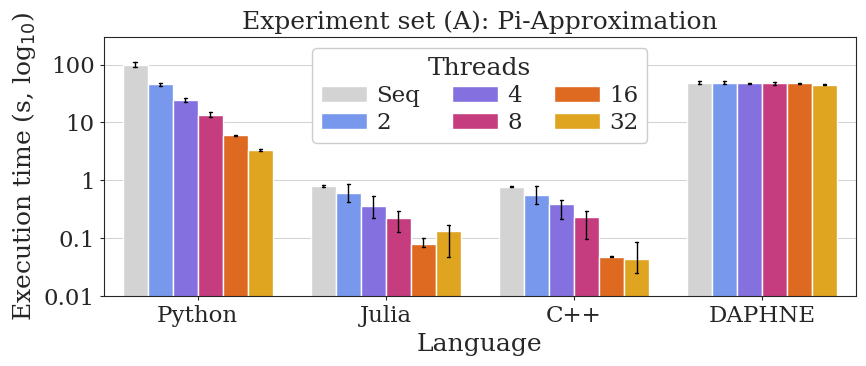

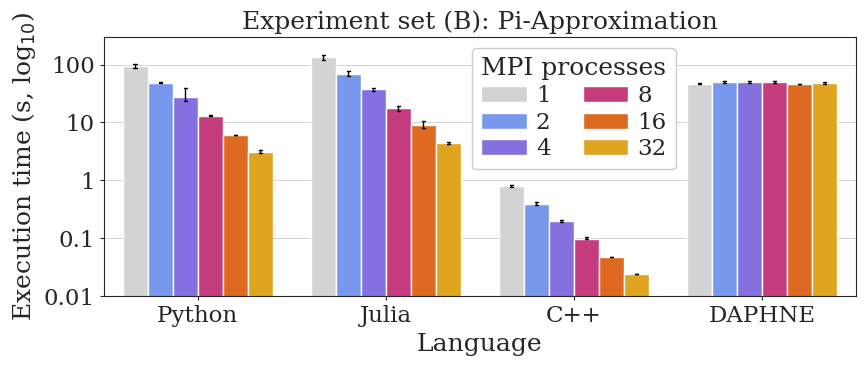

/tmp/ipykernel_1702657/2472282979.py:160: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(


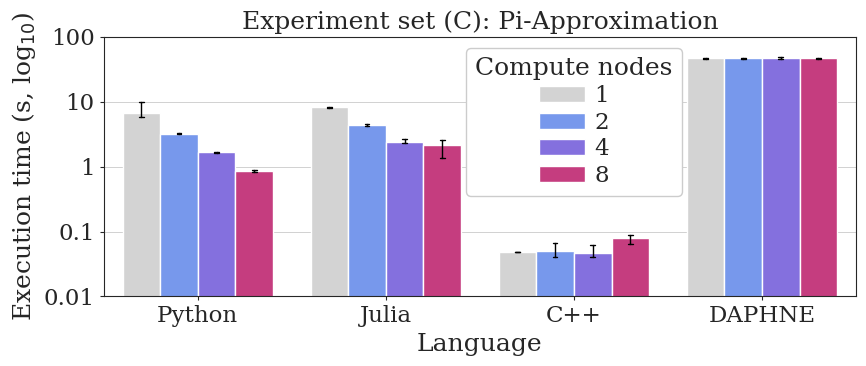

In [13]:
# output path for svg plots
path_svg = './performance/'
algo = 'Pi-Approximation'
log_base = 10

# plots are produced in loops

plot_loop = {
    'A_pi' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'threads-per-process',
        'on_hue_label' : 'Threads',        
        'columns' : ['value', 'language', 'threads-per-process'],
        'filter_cols' : [
            ('threads-per-process', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['Seq', '(A)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (A): {algo}',
        'loc' : 'upper center',   
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-2, 3e2]
    },   
    'B_pi' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'processes-per-node',
        'on_hue_label' : 'MPI processes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('processes-per-node', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['(B)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (B): {algo}',
        'loc' : 'upper center',   
        'loc_box': (0.625, 1.0),
        'ncol' : 2,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-2, 3e2]  
    },       
    'C_pi' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'nodes',
        'on_hue_label' : 'Compute nodes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('nodes', [1,2,4,8]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # needed for ordering 
            ('type', ['(C)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (C): {algo}',
        'loc' : 'upper center',   
        'loc_box': (0.625, 1.0),        
        'ncol' : 1,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-2, 1e2]   
    }, 
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = [t[1] for t in v.get('filter_cols') if t[0] == on_x][0]  # x order from filter_cols
    hue_order = [t[1] for t in v.get('filter_cols') if t[0] == on_hue][0] if on_hue is not None else None  # hue order from filter_cols

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # as Seq and (A) have a 1 thread experiments, remove (A) with 1 thread from df
    df = df[~((df['type'] == '(A)') & (df['threads-per-process'] == 1))]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # # search order as defined in plot loop
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    # x_order = tuple_[1]
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    # hue_order = tuple_[1]

    # print(df)
    # print(data)
    # sys.exit(0)

    # if data[on_hue].nunique() <= 5:
    #     palette_ = custom_palette[:data[on_hue].nunique()]
    # else:
    palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    ax.set_yscale('log', base=log_base)
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.get_major_locator().set_params(numticks=10)    

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    if v.get('loc_box',None) is not None:
        leg = plt.legend(title=on_hue_label, 
                    loc=v.get('loc'), 
                    ncol=ncol, 
                    bbox_to_anchor=v.get('loc_box'),                    
                    labelspacing=0.2,
                    columnspacing=1.4,
                    handletextpad=0.4
                    )
    else:
        leg = plt.legend(title=on_hue_label, 
                        loc=v.get('loc'), 
                        ncol=ncol, 
                        labelspacing=0.2,
                        columnspacing=1.4,
                        handletextpad=0.4
                        )

    # check if list filter_cols contains type and if type contains (A)
    if any(t[0] == 'type' and '(A)' in t[1] for t in v.get('filter_cols')):
        for text in leg.get_texts():
            if text.get_text() in ("1", "1.0"):
                text.set_text("Seq")

    # if v.get('loc_box',None) is not None:
    #     leg = plt.legend(title=on_hue_label, loc=v.get('loc'), bbox_to_anchor=v.get('loc_box'), ncol=ncol)
    # else:
    #     leg = plt.legend(title=on_hue_label, loc=v.get('loc'), ncol=ncol)
    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)

### Performance Plots N-Body
<a id='perf_ms'></a>

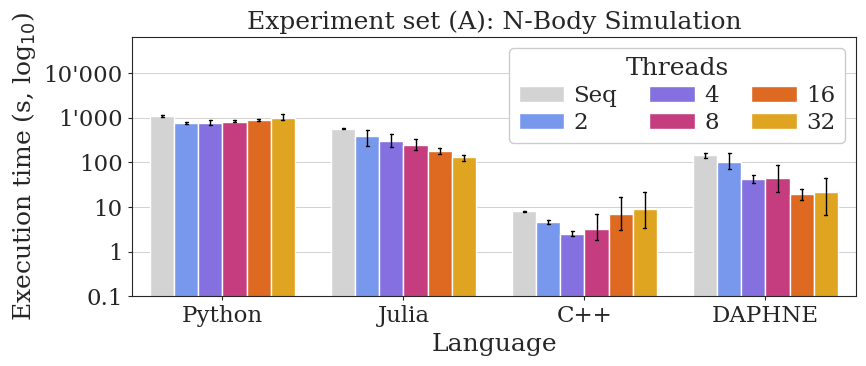

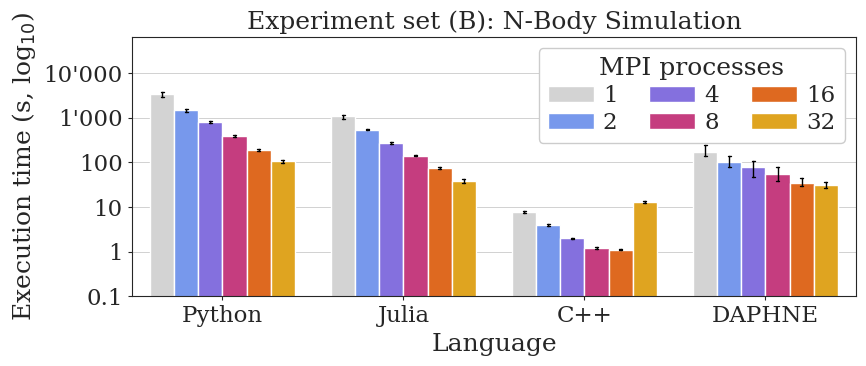

/tmp/ipykernel_1702657/897981660.py:160: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(


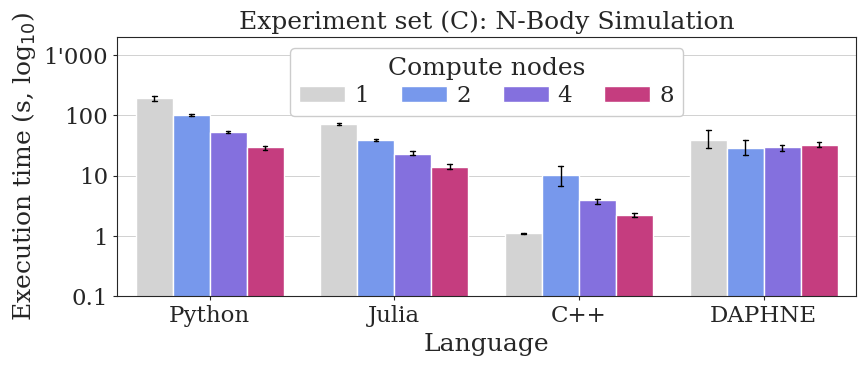

In [14]:
# output path for svg plots
path_svg = './performance/'
algo = 'N-Body Simulation'
log_base = 10

# plots are produced in loops

plot_loop = {
    'A_nbody' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'threads-per-process',
        'on_hue_label' : 'Threads',        
        'columns' : ['value', 'language', 'threads-per-process'],
        'filter_cols' : [
            ('threads-per-process', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['Seq', '(A)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (A): {algo}',
        'loc' : 'upper right',  
        # 'loc_box': (0.625, 1.0),             
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-1, 6.5e4]
    },   
    'B_nbody' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'processes-per-node',
        'on_hue_label' : 'MPI processes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('processes-per-node', [1,2,4,8,16,32]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # for ordering on plot too
            ('nodes', [1]),
            ('type', ['(B)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (B): {algo}',
        'loc' : 'upper right',   
        # 'loc_box': (0.625, 1.0),        
        'ncol' : 3,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-1, 6.5e4]  
    },       
    'C_nbody' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : f'Execution time (s, log$_{{{log_base}}}$)',
        'on_x' : 'language',
        'on_x_label' : 'Language',
        'on_hue' : 'nodes',
        'on_hue_label' : 'Compute nodes',        
        'columns' : ['value', 'language', 'processes-per-node'],
        'filter_cols' : [
            ('nodes', [1,2,4,8]),  # hue filter list
            ('benchmark', [algo]),
            ('language', ['Python', 'Julia', 'C++', 'DAPHNE']), # needed for ordering 
            ('type', ['(C)']),
            ('metric', ['t-end-to-end']),
        ],
        'title' : f'Experiment set (C): {algo}',
        'loc' : 'upper center',             
        'ncol' : 4,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        # 'ylim' : [0, 900],
        'ylim': [1e-1, 2e3]   
    }, 
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = [t[1] for t in v.get('filter_cols') if t[0] == on_x][0]  # x order from filter_cols
    hue_order = [t[1] for t in v.get('filter_cols') if t[0] == on_hue][0] if on_hue is not None else None  # hue order from filter_cols

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # as Seq and (A) have a 1 thread experiments, remove (A) with 1 thread from df
    df = df[~((df['type'] == '(A)') & (df['threads-per-process'] == 1))]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # # search order as defined in plot loop
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('x_order')), None)
    # x_order = tuple_[1]
    # tuple_ = next((item for item in v.get('filter_cols') if item[0] == v.get('hue_order')), None)
    # hue_order = tuple_[1]

    # print(df)
    # print(data)
    # sys.exit(0)

    # if data[on_hue].nunique() <= 5:
    #     palette_ = custom_palette[:data[on_hue].nunique()]
    # else:
    palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    ax.set_yscale('log', base=log_base)
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.get_major_locator().set_params(numticks=10)    

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    if v.get('loc_box',None) is not None:
        leg = plt.legend(title=on_hue_label, 
                    loc=v.get('loc'), 
                    ncol=ncol, 
                    bbox_to_anchor=v.get('loc_box'),                    
                    labelspacing=0.2,
                    columnspacing=1.4,
                    handletextpad=0.4
                    )
    else:
        leg = plt.legend(title=on_hue_label, 
                        loc=v.get('loc'), 
                        ncol=ncol, 
                        labelspacing=0.2,
                        columnspacing=1.4,
                        handletextpad=0.4
                        )

    # check if list filter_cols contains type and if type contains (A)
    if any(t[0] == 'type' and '(A)' in t[1] for t in v.get('filter_cols')):
        for text in leg.get_texts():
            if text.get_text() in ("1", "1.0"):
                text.set_text("Seq")
                
    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)

## Python 3.14 no GIL tests
<a id='python'></a>

### Load results

In [18]:
# load and read data
paths_results = [
    '../python-pre-experiments/results-py/',                     
]

# file name to text mapper
mapper = {
    'mp-imap': 'Mp-\nIMap',
    'mp-map': 'Mp-\nMap',
    'mp-imap-unordered': 'Mp-\nIMap\nUnordered',
    'mp-threads': 'Mp-\nThreads',
    'mpi4py': 'mpi4py',
    'numba': 'Numba',
    'omp4py-dynamic': 'omp4py\nDynamic',
    'omp4py-static': 'omp4py\nStatic',
    'omp4py-guided': 'omp4py\nGuided',
    'pyomp': 'PyOmp',
    'seq': 'Sequential\nPython',
    'numpy': 'NumPy',
    'threads': 'Thread-\ning',
    'py314t': 'Python v3.14 GIL-free',
    'py314': 'Python v3.14 GIL-bound',
    'py312': 'Python v3.12'
}

# all DAT files
all_files = []
for path in paths_results:
    all_files.extend(glob.glob(os.path.join(path, '*.txt'), recursive=True))

# read all DAT files and combine them into a single DataFrame
df_list = []

for filepath in all_files:
    
    parts = os.path.basename(filepath).split('_')

    # get information about the algorithm, the language and the type from the filename
    algo = mapper.get(parts[0], pd.NA)
    pyV = mapper.get(parts[1], pd.NA)
    processes = int(parts[2].removeprefix('p'))
    threads = int(parts[3].removeprefix('t'))
    rep = int(parts[4].split('.')[0].removeprefix('r'))  # remove the .dat extension
    t_ete = 't-end-to-end'
    workers = processes * threads

    # dataframe column names
    col_names=['parallelFramework',
            'pythonVersion',
            'workers',
            'processes_ranks',
            'threads',
            'rep',
            'intervals',
            't-end-to-end',
            'checksum'
           ]
    
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        line = [l for l in lines if 'Time' in l][0]
        seconds = float(line.strip().split(' ')[3])
        line = [l for l in lines if 'Approximation' in l][0]
        intervals = int(line.strip().split(' ')[5].replace("'",''))
        result = float(line.strip().split(' ')[7])        
    except Exception as e:
        print(f"File {filepath}: empty line")
        continue

    # create an empty DataFrame with the specified columns
    df = pd.DataFrame(columns=col_names)
    # insert values into the first row (index 0)
    df.loc[0] = [
        algo,        # benchmark
        pyV,        # language    
        int(workers),
        int(processes),     
        int(threads),
        int(rep),
        int(intervals),
        float(seconds),
        float(result)
    ]
    
    df_list.append(df)                    

df_wide = pd.concat(df_list, axis=0, ignore_index=True)

# make it a tidy DataFrame
df_long = pd.melt(
    df_wide,
    id_vars=['parallelFramework', 'pythonVersion', 'workers', 'processes_ranks', 'threads', 'rep','intervals','checksum'],  # keep these as identifiers
    value_vars=['t-end-to-end'],  # metrics to melt
    var_name='metric',
    value_name='value'
)

# show
df_long.head(10)    
#df_long['ParallelFramework'].unique()

,parallelFramework,pythonVersion,workers,processes_ranks,threads,rep,intervals,checksum,metric,value
0,Mp-\nIMap\nUnordered,Python v3.14 GIL-free,1,1,1,2,500000000,3.141593,t-end-to-end,119.119388
1,omp4py\nGuided,Python v3.14 GIL-free,4,1,4,3,500000000,3.141593,t-end-to-end,21.943075
2,Sequential\nPython,Python v3.14 GIL-free,1,1,1,2,500000000,3.141593,t-end-to-end,89.527479
3,Mp-\nIMap\nUnordered,Python v3.14 GIL-bound,1,1,1,5,500000000,3.141593,t-end-to-end,99.174728
4,Mp-\nThreads,Python v3.14 GIL-free,4,1,4,3,500000000,3.141593,t-end-to-end,28.700434
5,NumPy,Python v3.14 GIL-bound,1,1,1,1,500000000,3.141593,t-end-to-end,10.485781
6,mpi4py,Python v3.14 GIL-bound,4,4,1,4,500000000,3.141593,t-end-to-end,22.757805
7,NumPy,Python v3.14 GIL-free,2,1,2,3,500000000,3.141593,t-end-to-end,11.230349
8,mpi4py,Python v3.14 GIL-free,4,4,1,1,500000000,3.141593,t-end-to-end,30.494916
9,Mp-\nMap,Python v3.14 GIL-free,4,1,4,1,500000000,3.141593,t-end-to-end,31.992575


### Plots

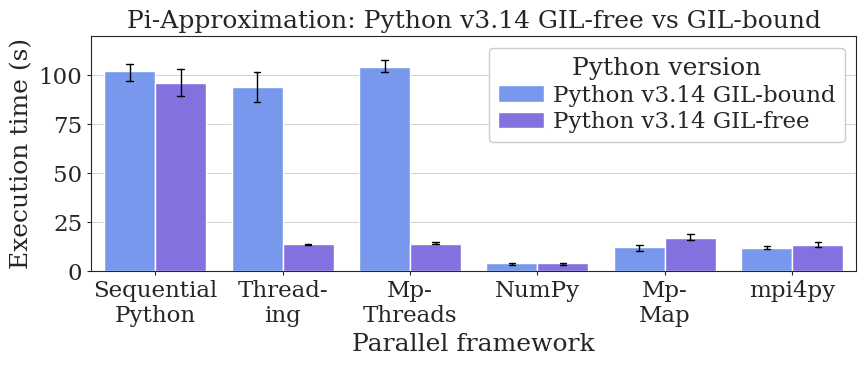

/tmp/ipykernel_1678739/2822800517.py:135: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  ax = sns.barplot(


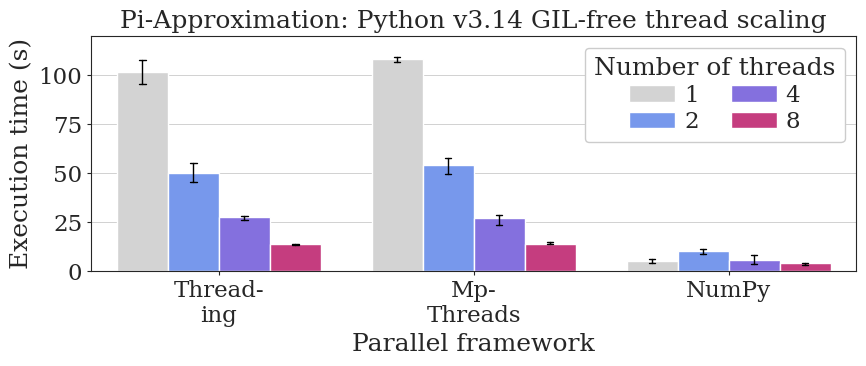

In [21]:
# output path for svg plots
path_svg = './pre-experiments/'

# plots are produced in loops

plot_loop = {
    'py314_vs_py314t' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'parallelFramework',
        'on_x_label' : 'Parallel framework',
        'on_hue' : 'pythonVersion',
        'on_hue_label' : 'Python version',        
        'columns' : ['value', 'parallelFramework', 'pythonVersion'],
        'filter_cols' : [
            ('workers', [1,8]),
            ('metric', ['t-end-to-end']),
            ('pythonVersion', [ 'Python v3.14 GIL-bound','Python v3.14 GIL-free']),
            ('parallelFramework', ['Sequential\nPython', 'Thread-\ning', 'Mp-\nThreads', 'NumPy', 'Mp-\nMap' ,'mpi4py']),
        ],
        'filter_cols_conditional' : [ # set to None if not needed
            ('workers', [8]),
            ('parallelFramework', ['Sequential\nPython']),
        ],
        'title' : 'Pi-Approximation: Python v3.14 GIL-free vs GIL-bound',
        'loc' : 'upper right',   
        'ncol' : 1,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 120],
        'x_order' : ['Sequential\nPython', 'Thread-\ning', 'Mp-\nThreads', 'NumPy', 'Mp-\nMap' ,'mpi4py'],
        'hue_order' : ['Python v3.14 GIL-bound','Python v3.14 GIL-free'],
    },
    'py314t_scaling' : {
        'speedup_plot' : False,  # make speedup plot (normalize by seq)
        'on_y' : 'value',
        'on_y_label' : 'Execution time (s)',
        'on_x' : 'parallelFramework',
        'on_x_label' : 'Parallel framework',
        'on_hue' : 'threads',
        'on_hue_label' : 'Number of threads',        
        'columns' : ['value', 'parallelFramework', 'pythonVersion'],
        'filter_cols' : [
            ('threads', [1,2,4,8]),
            ('metric', ['t-end-to-end']),
            ('pythonVersion', ['Python v3.14 GIL-free']),
            ('parallelFramework', ['Thread-\ning', 'Mp-\nThreads', 'NumPy']),
        ],
        'filter_cols_conditional' : None, # set to None if not needed, or delete, same effect
        'title' : 'Pi-Approximation: Python v3.14 GIL-free thread scaling',
        'loc' : 'upper right',   
        'ncol' : 2,  # num columns in legend: 'auto'=from hue order, 'norm'=from hue order -1 as speedup or normalize, integer number
        'annotate' : False, 
        'annotate_rotated' : True,  # rotate the annotation text
        'ylim' : [0, 120],
        'x_order' : ['Thread-\ning', 'Mp-\nThreads', 'NumPy'],
        'hue_order' : [1,2,4,8],
    }     
}

for k,v in plot_loop.items():
    df = df_long.copy()
    # what we want to display
    on_x = v.get('on_x')
    on_x_label = v.get('on_x_label')
    on_y = v.get('on_y')
    on_y_label= v.get('on_y_label')
    on_hue = v.get('on_hue')
    on_hue_label = v.get('on_hue_label')
    x_order = v.get('x_order')
    hue_order = v.get('hue_order')

    # columns
    columns = v.get('columns')

    ##### Change this and the name to make and save another plot
    filter_cols = v.get('filter_cols') 
    # name of the plot
    title = v.get('title')
    plot_name = '{}'.format(k)

    # Filter data
    for filt in filter_cols:
        if filt[1] is None:
            df = df[(df[filt[0]].isnull())]
        else:
            df = df[(df[filt[0]].isin(filt[1]))]

    # secondary filter cols
    if v.get('filter_cols_conditional', None) is not None:
        conditional = v.get('filter_cols_conditional')
        cond_mask = False
        for col, allowed in conditional:
            cond_mask |= df[col].isin(allowed)

        df = df[cond_mask]

    if v.get('speedup_plot', False):

        # average over repetitions
        df = df.groupby(['benchmark', 'language', 'type', v.get('filter_cols')[0][0]]).agg({'value': 'mean'}).reset_index()

        # Speedup. Divide the rows by the row entry for seq for each language
        df_norm = df.copy()

        # step 1: Create a column with the base "Seq" value per (benchmark, language)
        seq_values = df_norm[df_norm['type'] == 'Seq'].set_index(['benchmark', 'language'])['value']
        df_norm['seq_base'] = df_norm.set_index(['benchmark', 'language',]).index.map(seq_values)

        # step 2: Normalize
        df_norm['speedup'] =  df_norm['seq_base'] / df_norm['value']

        # print(df_norm)

        df_norm['value'] = df_norm['speedup']
        data = df_norm.drop(columns=['speedup', 'seq_base'])

        # remove threads=1 rows
        data = data[data['threads-per-process'] != 1]
    else:
        data = df.copy()

    # print(df)
    # print(data)
    # sys.exit(0)

    if data[on_hue].nunique() <= 3:
        palette_ = custom_palette[:data[on_hue].nunique()]
    else:
        palette_ = [custom_palette[5]] + custom_palette[:5]

    # Plot the bar plot using seaborn
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(
        data=data,
        x=on_x,
        order = x_order,
        y=on_y,
        hue=on_hue,     
        hue_order=hue_order,  # hue order from filter_cols
        estimator=np.mean, 
        #errorbar=None,
        errorbar = lambda x: (x.min(), x.max()), 
        palette=palette_,
        capsize=0.1,  # Controls the size of the caps on the error bars
        err_kws={'color': 'black', 'linewidth': 1} # Width of the error bars       
    )

    # Set plot properties
    plt.xlabel(on_x_label)
    plt.ylabel(on_y_label)

    # Add thin grid lines at y-axis ticks
    make_grid(ax, plt)

    # set y axis limits for plot to fit
    if not v.get('ylim',None) is None:
        l,u = v.get('ylim')
        plt.ylim(l,u)

    # Set the title using plt.title()
    plt.title(title)

    # Place the legend at the top-right corner
    ncol =  v.get('ncol') 
    if ncol == 'auto':
        ncol = len(v.get('filter_cols')[0][1])  # number of unique hues
    if ncol == 'norm':
        ncol = len(v.get('filter_cols')[0][1]) - 1  # number of unique hues   

    leg = plt.legend(title=on_hue_label, 
                    loc=v.get('loc'), 
                    ncol=ncol, 
                    labelspacing=0.2,
                    columnspacing=1.4,
                    handletextpad=0.4
                    )
    
    leg.get_frame().set_alpha(1) 
    # horizontal line
    if v.get('speedup_plot', False):
        plt.axhline(y=1, color=grey_shades[1], linestyle='--')

    # Format the y-axis ticks with a space as a thousand separator
    # Format legend labels with a space as a thousand separator
    formatter(ax)

    # Annotate each bar with the formatted value
    if v.get('annotate', False):
        annotater(ax, plt, v.get('annotate_rotated', False), v.get('ylim', None))

    # finish, save and plot
    finisher(plot_name, plt)

### Profiling

100000
       tid        start     duration   label
0  2143707     0.000000  1103.684367    main
1  2143707  1103.684367  7251.530417    pool
2  2143707  8355.218176   100.000000  finish
3  2143747  1103.747638  7139.344360  worker
4  2143746  1103.755218  7155.974442  worker
5  2143748  1114.462819  7209.553089  worker
6  2143749  1123.485267  7231.456846  worker


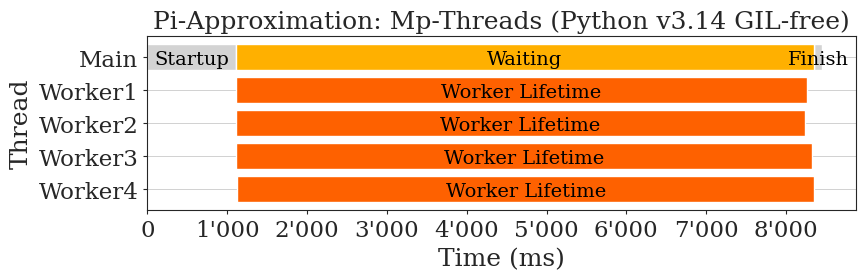

100000
       tid         start      duration   label
0  1552588      0.000000    100.000000    main
1  1552588    117.280188  10511.573760    pool
2  1552588  10628.857078    100.000000  finish
3  1552614    132.722819   9479.195564  worker
4  1552615    168.281865   9838.066168  worker
5  1552612    122.526966  10320.074038  worker
6  1552613    117.388729  10510.805873  worker


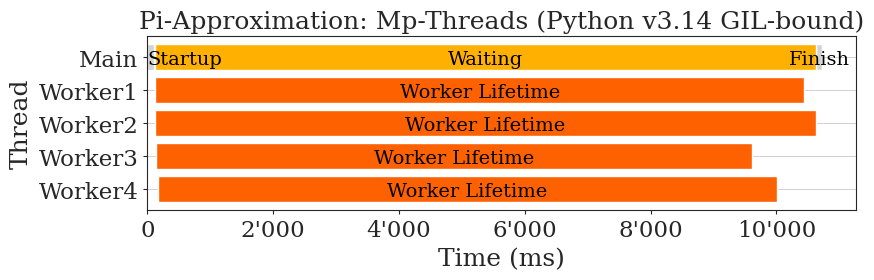

In [59]:
# output path for svg plots
path_svg = './pre-experiments/'

trace_files = {
    'mp_threads_GIL-free': {
        'file': 'mp-threads_py314t_p1_t4_profile.json',
        'title': 'Pi-Approximation: Mp-Threads (Python v3.14 GIL-free)',
        'fig_size': (fig_width, fig_height * 0.7),
        'search_map_' : { 
            "main": "builtins.exec",
            "pool": "Pool.map",
            "worker": "worker_sum",
            "finish": "Pool.__exit__"
        },
        'label_map_' : {
            "main": "Startup",
            "pool": "Waiting",
            "worker": "Worker Lifetime",
            "finish": "Finish"
        }
    },
    'mp_threads_GIL-bound': {
        'file': 'mp-threads_py314_p1_t4_profile.json',
        'title': 'Pi-Approximation: Mp-Threads (Python v3.14 GIL-bound)',
        'fig_size': (fig_width, fig_height * 0.7),
        'search_map_' : { 
            "main": "builtins.exec",
            "pool": "Pool.map",
            "worker": "worker_sum",
            "finish": "Pool.__exit__"
        },        
        'label_map_' : {
            "main": "Startup",
            "pool": "Waiting",
            "worker": "Worker Lifetime",
            "finish": "Finish"
        },        
        'offset_text': {
            "main": 550,
        },
    }
}

for trace_file_key, val in trace_files.items():
# read the traces
    with open(os.path.join('../python-pre-experiments/results-py/profiling/viztracer', val['file'])) as f:
        data = json.load(f)

    events = data["traceEvents"]

    rows = []
    main_start_ts = None
    main_tid = None

    # First pass: find main event
    for ev in events:
        name = ev.get("name", "")
        if (isinstance(name, str) and name.startswith(val.get('search_map_').get("main",None))):
            main_ts = ev.get("ts")
            main_tid = ev.get("tid")
            main_dur = ev.get("dur", 0.0)
            if main_dur < 100000:  # make dur visible
                main_dur = 100000
            break

    # last timestamp on main thread = end of main lifetime
    main_events = [ev.get("ts", 0) + ev.get("dur", 0) for ev in events if ev["tid"] == main_tid]
    main_last_ts = max(main_events)

    # Second pass: find main "experiments" event
    for ev in events:
        name = ev.get("name", "")
        if (isinstance(name, str) and name.startswith(val.get('search_map_').get("pool",None))):
            pool_ts = ev.get("ts")
            pool_tid = ev.get("tid")
            pool_dur = ev.get("dur", 0.0)
            break

    # Third pass: find main "experiments" event
    for ev in events:
        name = ev.get("name", "")
        if (isinstance(name, str) and name.startswith(val.get('search_map_').get("finish",None))):
            poolend_ts = ev.get("ts")
            poolend_tid = ev.get("tid")
            poolend_dur = ev.get("dur", 0.0)
            if poolend_dur < 100000:  # make dur visible
                poolend_dur = 100000
            break

    print(poolend_dur)

    rows.append({
        "tid": main_tid,
        "start": 0,          # normalized
        "duration": max(pool_ts - main_ts, main_dur),  # extend to end of main thread
        "label": "main"
    })
    if main_dur != 100000:
        main_dur = 0
    rows.append({
        "tid": pool_tid,
        "start": pool_ts - main_ts + main_dur,         
        "duration": pool_dur,
        "label": "pool"
    })
    rows.append({
        "tid": poolend_tid,
        "start": poolend_ts - main_ts + main_dur,    
        "duration": poolend_dur,
        "label": "finish"
    })    

    # Fourth pass: worker_sum events
    for ev in events:
        name = ev.get("name", "")
        if isinstance(name, str) and name.startswith(val.get('search_map_').get("worker",None)):
            rows.append({
                "tid": ev.get("tid"),
                "start": ev.get("ts") - main_ts + main_dur,  
                "duration": ev.get("dur", 0.0),
                "label": "worker"
            })

    df = pd.DataFrame(rows)
    df["duration"] = df["duration"] / 1000  # convert to ms
    df["start"] = df["start"] / 1000  # convert to ms
    print(df)

    # Sort threads so main is ALWAYS at the top
    df = df.sort_values(["tid"], ascending=[False])  
    unique_tids = df["tid"].unique()

    # Create figure for horizontal Gantt
    fig_w, fig_h = val.get('fig_size')
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    colors_ = {
        "main": custom_palette[5] ,
        "worker": custom_palette[3] ,
        "pool": custom_palette[4] ,
        "finish": custom_palette[5] ,
    }
    label_map = val.get('label_map_')

    # Plot bars
    for i, tid in enumerate(unique_tids):
        sub = df[df["tid"] == tid]
        for _, row in sub.iterrows():

            # Draw bar
            ax.broken_barh(
                [(row["start"], row["duration"])],
                (i - 0.4, 0.8),
                facecolor=colors_.get(row["label"]),
            )

            # Annotation: center of bar
            x_center = row["start"] + row["duration"] / 2 + val.get('offset_text', {}).get(row["label"], 0)
            y_center = i - 0.05

            ax.text(
                x_center,
                y_center,
                label_map.get(row["label"]),
                ha="center",
                va="center",
                color="black",
                fontsize=font_size,
            )

    # remove pool and finish from df
    df = df[df["label"].isin(["pool","finish"]) == False]
    # Y-axis labels: label + TID
    yticklabels = []
    num = 4
    for tid in df["tid"].unique():
        lbl = df[df["tid"] == tid]["label"].iloc[0]
        nice = lbl.capitalize()
        #yticklabels.append(f"{nice} (tid={str(tid)[-2:]})")
        if lbl == "main":
            yticklabels.append(f"{nice}")
        else:
            yticklabels.append(f"{nice}{num}")
        num -= 1

    ax.set_yticks(range(len(unique_tids)))
    ax.set_yticklabels(yticklabels)

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Thread")

    # Title
    ax.set_title(val['title'])

    # Optional grid
    make_grid(ax, plt, ygrid=True, xgrid=False)

    # Set bounds
    ax.set_xlim(left=0)

    formatter(ax, None, 'x')

    # Save + show
    finisher(trace_file_key, plt)



     tid        start     duration   label
0  61792     0.000000  1279.715440    main
1  61792  1279.715440  1591.367327    pool
2  61792  2871.082767    30.000000  finish


/tmp/ipykernel_869096/539222022.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


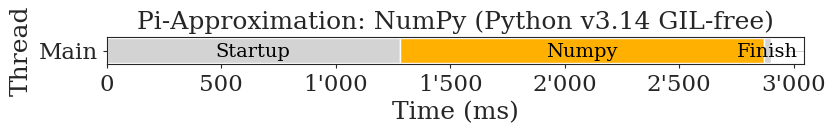

In [65]:
# output path for svg plots
path_svg = './pre-experiments/'

trace_files = {

    'numpy_GIL-free': {
        'file': 'numpy_py314t_p1_t4_profile.json',
        'title': 'Pi-Approximation: NumPy (Python v3.14 GIL-free)',
        'fig_size': (fig_width, fig_height * 0.08),
        'search_map_' : { 
            "main": "builtins.exec",
            "pool": "pi_numpy",
        },
        'label_map_' : {
            "main": "Startup",
            "pool": "Numpy",
            "finish": "Finish"            
        }
    }
}

for trace_file_key, val in trace_files.items():
# read the traces
    with open(os.path.join('../python-pre-experiments/results-py/profiling/viztracer', val['file'])) as f:
        data = json.load(f)

    events = data["traceEvents"]

    rows = []
    main_start_ts = None
    main_tid = None

    # First pass: find main event
    for ev in events:
        name = ev.get("name", "")
        if (isinstance(name, str) and name.startswith(val.get('search_map_').get("main",None))):
            main_ts = ev.get("ts")
            main_tid = ev.get("tid")
            main_dur = ev.get("dur", 0.0)
            if main_dur < 30000:  # make dur visible
                main_dur = 30000
            break

    # last timestamp on main thread = end of main lifetime
    main_events = [ev.get("ts", 0) + ev.get("dur", 0) for ev in events if ev["tid"] == main_tid]
    main_last_ts = max(main_events)

    # Second pass: find main "experiments" event
    for ev in events:
        name = ev.get("name", "")
        if (isinstance(name, str) and name.startswith(val.get('search_map_').get("pool",None))):
            pool_ts = ev.get("ts")
            pool_tid = ev.get("tid")
            pool_dur = ev.get("dur", 0.0)
            break

    rows.append({
        "tid": main_tid,
        "start": 0,          # normalized
        "duration": max(pool_ts - main_ts, main_dur),  # extend to end of main thread
        "label": "main"
    })
    if main_dur != 30000:
        main_dur = 0
    rows.append({
        "tid": pool_tid,
        "start": pool_ts - main_ts + main_dur,         
        "duration": pool_dur,
        "label": "pool"
    })
    rows.append({
        "tid": pool_tid,
        "start": pool_ts - main_ts + main_dur + pool_dur,         
        "duration": 30000, # its so short, make it visible
        "label": "finish"
    })    

    df = pd.DataFrame(rows)
    df["duration"] = df["duration"] / 1000  # convert to ms
    df["start"] = df["start"] / 1000  # convert to ms
    print(df)

    # Sort threads so main is ALWAYS at the top
    df = df.sort_values(["tid"], ascending=[False])  
    unique_tids = df["tid"].unique()

    # Create figure for horizontal Gantt
    fig_w, fig_h = val.get('fig_size')
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    colors_ = {
        "main": custom_palette[5] ,
        "worker": custom_palette[3] ,
        "pool": custom_palette[4] ,
        "finish": custom_palette[5] ,
    }
    label_map = val.get('label_map_')
    
    # Plot bars
    for i, tid in enumerate(unique_tids):
        sub = df[df["tid"] == tid]
        for _, row in sub.iterrows():

            # Draw bar
            ax.broken_barh(
                [(row["start"], row["duration"])],
                (i - 0.4, 0.8),
                facecolor=colors_.get(row["label"]),
            )

            # Annotation: center of bar
            x_center = row["start"] + row["duration"] / 2
            y_center = i - 0.05

            ax.text(
                x_center,
                y_center,
                label_map.get(row["label"]),
                ha="center",
                va="center",
                color="black",
                fontsize=font_size,
            )

    # remove pool and finish from df
    df = df[df["label"].isin(["pool","finish"]) == False]
    # Y-axis labels: label + TID
    yticklabels = []
    num = 4
    for tid in df["tid"].unique():
        lbl = df[df["tid"] == tid]["label"].iloc[0]
        nice = lbl.capitalize()
        #yticklabels.append(f"{nice} (tid={str(tid)[-2:]})")
        if lbl == "main":
            yticklabels.append(f"{nice}")
        else:
            yticklabels.append(f"{nice}{num}")
        num -= 1

    ax.set_yticks(range(len(unique_tids)))
    ax.set_yticklabels(yticklabels)

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Thread")

    # Title
    ax.set_title(val['title'])

    # Optional grid
    make_grid(ax, plt, ygrid=True, xgrid=False)

    # Set bounds
    ax.set_xlim(left=0)

    formatter(ax, None, 'x')

    # Save + show
    finisher(trace_file_key, plt)

